10000.0 131 0.40307692307692305 0.0003546563651975838
1000.0 134 0.4123076923076923 0.020770162955461736
100.0 260 0.8 0.7425473239247798
10.0 298 0.916923076923077 8.007283909126876
1.0 320 0.9846153846153847 54.297714628692205
0.1 323 0.9938461538461538 271.8431813848007
0.01 324 0.9969230769230769 686.4498002979319
0.001 324 0.9969230769230769 693.5745686112396
0.0001 324 0.9969230769230769 694.2224383063515
1e-05 324 0.9969230769230769 694.2866962581419


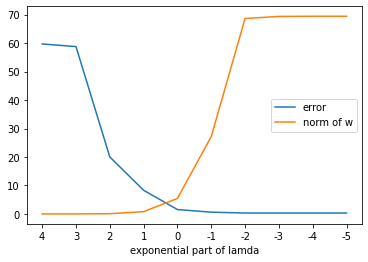

In [6]:
########################################
#Solar Energy Classification
#Group 3
#Pengkai Wang, Kaiwen Zheng, Jiahe Zhang
########################################

from autograd import grad
from autograd import numpy as np
import matplotlib.pyplot as plt
from autograd.misc.flatten import flatten_func
import pandas as pd
import time

data = pd.read_csv("ENGR_518_group_3_datasets.csv")

number = data['USAF'].values
latitude = data['Latitude'].values
longitude = data['Longitude'].values
etr = data['Avg hourly ETR in 2005 (Wh/m^2)'].values
length = number.size
train_length = 600
test_length = length - train_length
classes = np.empty(length,dtype=int)

#standard normalization
var_x = np.var(longitude)
var_y = np.var(latitude)
mean_x = np.mean(longitude)
mean_y = np.mean(latitude)
x_norm = (longitude - mean_x)/np.sqrt(var_x)
y_norm = (latitude - mean_y)/np.sqrt(var_y)
N = 2 #No. of features

#define classes labels
C = 3 # No. of classes
for i in range(length):
    if etr[i] < 320:
        classes[i]=0
    elif 320 <= etr[i] < 340:
        classes[i]=1
    else:
        classes[i]=2


#split shuffled data for training and testing
x_train = x_norm[:train_length]
y_train = y_norm[:train_length]
classes_train = classes[:train_length]
x_test = x_norm[train_length:]
y_test = y_norm[train_length:]
classes_test = classes[train_length:]


# define model, which compute C linear combinations, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T


#define softmax function
def softmax(x):
    sum = np.sum(np.exp(x),axis=0,keepdims=True)
    return np.log(sum)


# multiclass perceptron cost function
lam = 0.01 # regularization param
def multiclass_perceptron(w):
    v = model(x,w) #xp*wj
    a = softmax(v) #softmax(xp*w)
    b = v[y.astype(int),np.arange(np.size(y))] #xp*wyp
    cost = np.sum(a-b)# compute cost using numpy broadcasting
    cost = cost + lam*np.linalg.norm(w[1:,:])**2 # add regularization parameter
    return cost/float(np.size(y)) # return average


# gradient descent function
def gradient_descent(g, step, max_its, w):
    g_flat, unflatten_func, w_flat = flatten_func(g,w) # flatten g
    gradient_func = grad(g_flat) #dg(w)/dw
    weight_history = [w_flat] # w history container start from initial w
    cost_history = [g_flat(w_flat)] # cost history container
    for k in range(max_its):
        gradient = gradient_func(w_flat) #gradient at point w
        grad_eval_norm = gradient / np.linalg.norm(gradient)
        alpha = 5/(k+1) #step size
        w_flat = w_flat - alpha*grad_eval_norm #w after this step of descent
        # push weight and cost into container
        weight_history.append(w_flat)
        cost_history.append(g_flat(w_flat))
    return weight_history, cost_history, unflatten_func


x = np.c_[x_train,y_train].T
y = classes_train.T.reshape(1,-1)
w = np.random.random((N+1,C)) #w0, w1, w2

iter = 1000

lam = 10**5 # reg param
w_norm = []
error = []
for n in range(10):
    lam = lam/10
    w_history, cost_history, unflatten = gradient_descent(multiclass_perceptron,'d',iter,w)
    wp = unflatten(w_history[iter])

    #verify test dataset
    data_verify = np.c_[x_test,y_test].T
    verify_result = z=np.argmax(model(data_verify, wp),axis=0)
    true_number = 0
    for i in range(test_length):
        if verify_result[i] == classes_test[i]:
            true_number = true_number +1
    w_norm.append(np.linalg.norm(wp[1:,:],'fro')**2/10)
    print(lam, true_number, true_number/test_length,np.linalg.norm(wp[1:,:],'fro')**2)
    error.append(100*(1-true_number/test_length))

plt.xticks(np.arange(0,10),np.arange(4,-6,-1))
plt.xlabel('exponential part of lamda')
plt.plot(error, label='error')
plt.plot(w_norm, label='norm of w')
plt.legend()
plt.show()
